In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from IPython.core.display import display, HTML

from hisscube.utils.photometry import Photometry

display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt


h5_path = "../data/processed/galaxy_small.h5"
photometry = Photometry()



Cutout distance metric: 1.085429e-20
Spectrum distance metric: 1.085429e-20
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


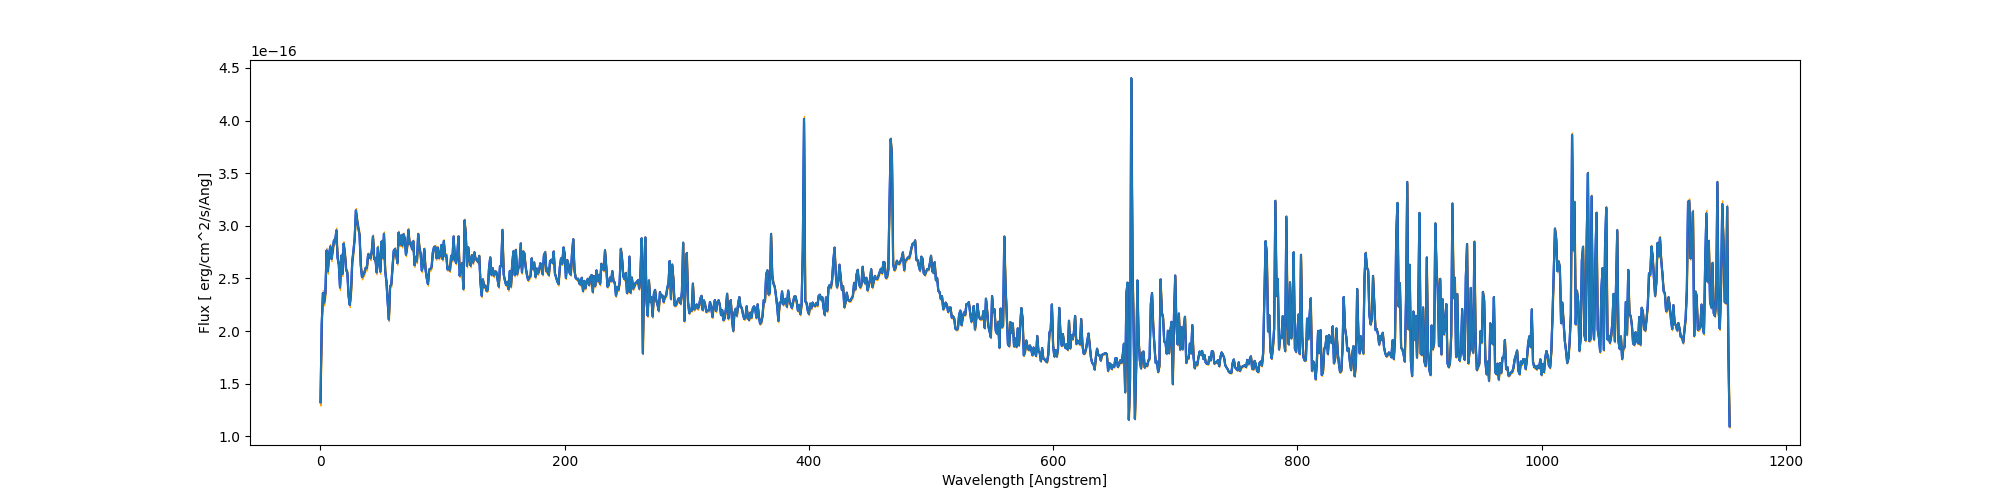

<HDF5 dataset "spectral_1d_cube_zoom_2": shape (2, 1155), type "<f4">


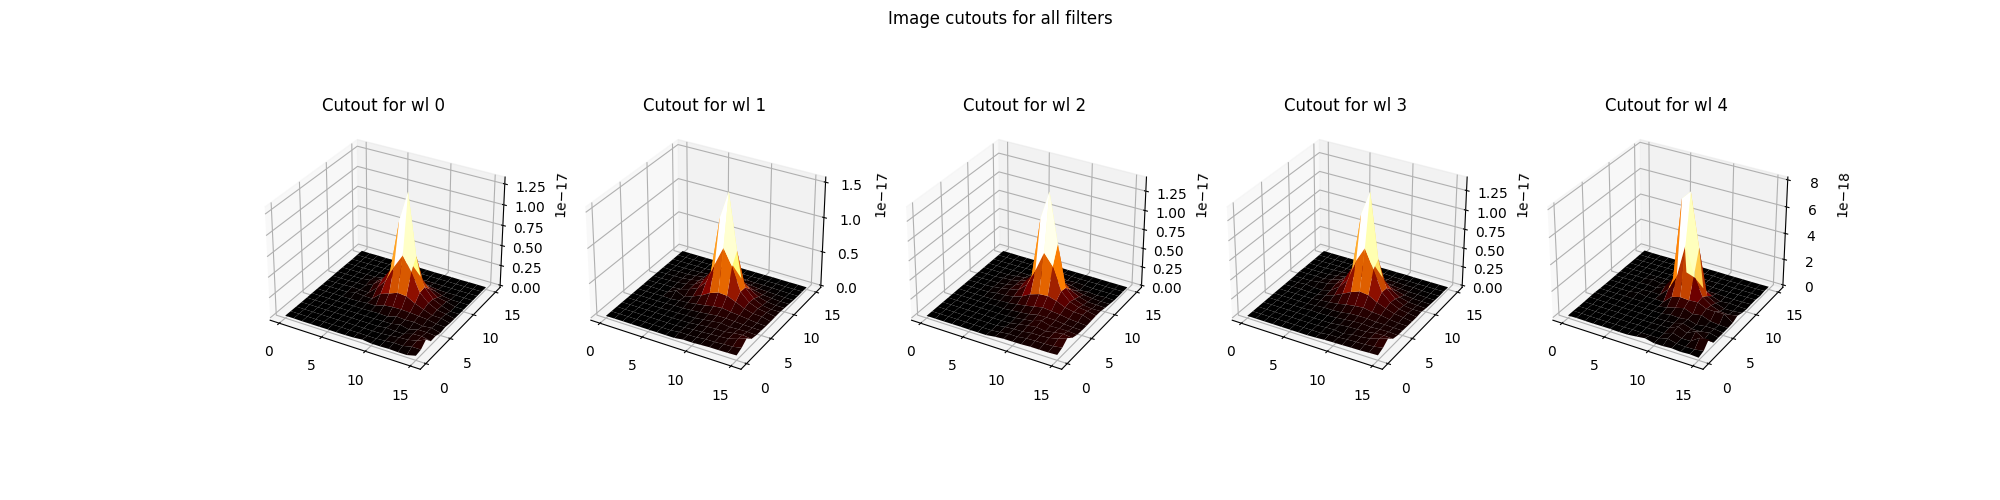

In [2]:
from hisscube.processors.metadata_strategy_cube_ml import target_distance, DatasetMLProcessorStrategy
from hisscube.utils.io_strategy import SerialDatasetIOStrategy
%matplotlib widget
from hisscube.processors.cube_ml import MLProcessor
from hisscube.utils.io import SerialH5Reader
from hisscube.utils.config import Config

zoom = 2
cutouts, specs = None, None
cutout, spec = None, None

def plot_cutout(cutouts, fig, nrows, ncols):
    for idx, cutout in enumerate(cutouts):
        ax = fig.add_subplot(nrows,ncols,idx+1, projection='3d')
        print (cutout.shape)
        x = range(0,cutout.shape[0])
        y = range(0,cutout.shape[1])
        xv, yv = np.meshgrid(x,y)
        pixels = cutout
        print (pixels.shape)
        dem3d=ax.plot_surface(xv,yv,pixels,cmap='afmhot', linewidth=0)
        ax.set_title('Cutout for wl %d' % idx)
        
        
config = Config()
io_strategy = SerialDatasetIOStrategy()
h5_serial_reader = SerialH5Reader(h5_path, config, io_strategy)
cube_ml_strategy = DatasetMLProcessorStrategy(config, io_strategy, photometry)



with h5_serial_reader as h5_connector:
    processor = MLProcessor(cube_ml_strategy)
    cutout, cutout_sigma, spec, spec_sigma = processor.get_data(h5_connector, zoom)
    target_count = processor.get_target_count(h5_connector)
    cutout_1, spec_1 = cutout, spec

    cutouts = np.reshape(cutout, (target_count,-1))
    specs = np.reshape(cutout, (target_count,-1))


    cutout_distance = target_distance(cutouts[0], cutouts[1])
    spec_distance = target_distance(specs[0], specs[1])


    print("Cutout distance metric: %e" % cutout_distance)
    print("Spectrum distance metric: %e" % spec_distance)

    fig = plt.figure(figsize=(20,5))
    fig.suptitle('Image cutouts for all filters')
    plot_cutout(cutout[0], fig, 1, 5)
    fig2 = plt.figure(figsize=(20,5))
    wl = range(0, spec_1[0].shape[0])
    flux = spec_1[0, :] 
    flux_sigma = spec_sigma[0,:]
    ax = plt.axes(xlabel="Wavelength [Angstrem]", ylabel="Flux [ erg/cm^2/s/Ang]")
    ax.plot(wl, flux, color="blue")
    ax.fill_between(wl,
                    flux - flux_sigma,
                    flux + flux_sigma,
                    color="orange")
    ax.plot(wl, flux)

    plt.show()
    print(spec_1)
    


    


b'spec-0412-51871-0308.fits'


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


               heal_id         ra       dec     time      wl          mean  \
0        1557517971485  46.560471 -0.344359  51871.0  3840.0  5.585810e-16   
1        1557517971485  46.560471 -0.344359  51871.0  3840.0  5.160802e-16   
2        1557517971485  46.560471 -0.344359  51871.0  3840.0  4.102621e-16   
3        1557517971485  46.560471 -0.344359  51871.0  3844.0  5.013351e-16   
4        1557517971485  46.560471 -0.344359  51871.0  3844.0  5.152129e-16   
...                ...        ...       ...      ...     ...           ...   
4138623  1557517971485  46.563873 -0.341489  52173.0  3551.0 -1.979940e-19   
4138624  1557517971485  46.563873 -0.341379  52173.0  3551.0  2.096407e-19   
4138625  1557517971485  46.563873 -0.341269  52173.0  3551.0  1.281137e-19   
4138626  1557517971485  46.563873 -0.341159  52173.0  3551.0 -3.499305e-20   
4138627  1557517971485  46.563873 -0.341049  52173.0  3551.0 -5.243134e-19   

                sigma    spec_ra  spec_dec                     

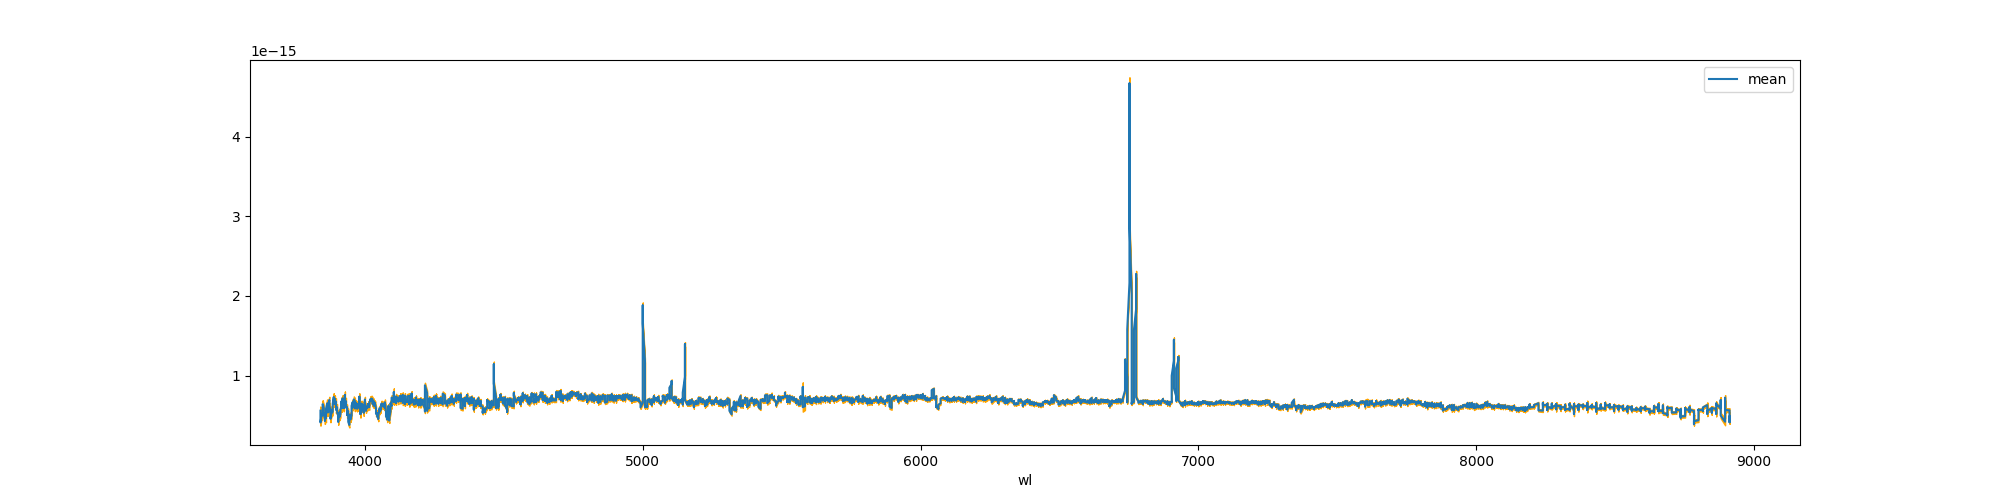

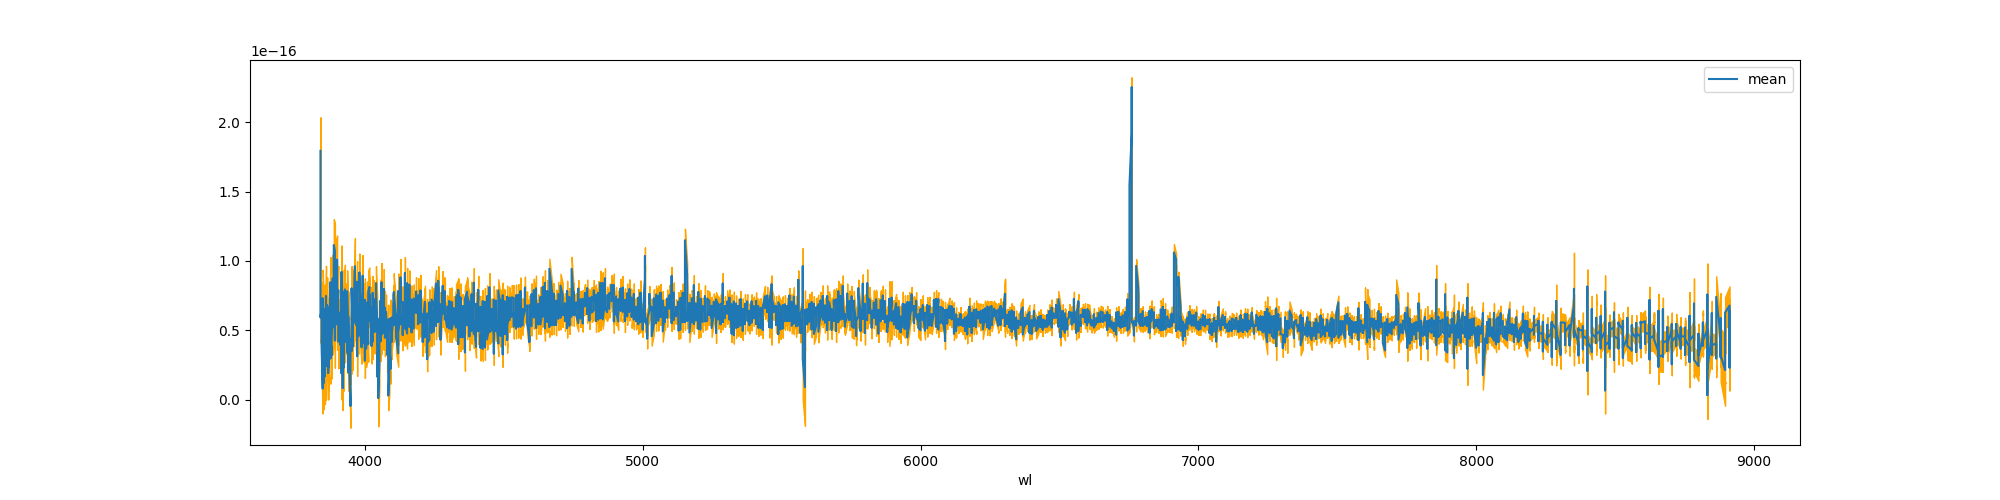

In [3]:
from hisscube.processors.metadata_strategy_cube_visualization import DatasetVisualizationProcessorStrategy
from hisscube.processors.cube_visualization import VisualizationProcessor
import pandas as pd


def plot_spec(spec_0):
    wl = spec_0["wl"]
    flux = spec_0["mean"]
    flux_sigma = spec_0["sigma"]
    ax = spec_0.plot(x="wl", y="mean", figsize=(20,5))
    ax.fill_between(wl, 
                    flux - flux_sigma, 
                    flux + flux_sigma, 
                    color="orange")
config = Config()
io_strategy = SerialDatasetIOStrategy()
h5_serial_reader = SerialH5Reader(h5_path, config, io_strategy)
cube_visualization_strategy = DatasetVisualizationProcessorStrategy(config, io_strategy, photometry)

with h5_serial_reader as h5_connector:
    processor = VisualizationProcessor(cube_visualization_strategy)
    processor.h5_connector = h5_connector
    cube_4d_table = processor.read_spectral_cube_table(h5_connector, 0)
    pd_cube = pd.DataFrame.from_records(cube_4d_table)
    print(pd_cube['fits_name'][0])
    condition = pd_cube['fits_name'] == b'spec-0412-51871-0308.fits'
    condition_1 = pd_cube['fits_name'] ==b'spec-0411-51817-0119.fits'
    spec_0 = pd_cube[condition].filter(["wl", "mean", "sigma"])
    spec_1 = pd_cube[condition_1].filter(["wl", "mean", "sigma"])
    plot_spec(spec_0)
    plot_spec(spec_1)
    print(pd_cube)
    pd_cube.groupby(['heal_id','fits_name']).count()
